## Example of Trans-C sampling across independent model states: Regression

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem
using the Ensemble resampler.

In [10]:
# general python utility packages
import time
from collections import Counter
from functools import partial

import corner
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [11]:
from pytransc.analysis.samples import resample_ensembles
from pytransc.analysis.visits import (
    count_state_changes,
    count_total_state_changes,
    get_acceptance_rate_between_states,
    get_autocorr_between_state_jumps,
    get_relative_marginal_likelihoods,
    get_visits_to_states,
)
from pytransc.samplers import run_ensemble_resampler, run_mcmc_per_state
from pytransc.utils.auto_pseudo import build_auto_pseudo_prior

In [12]:
def solveLS(d, G, Cdinv, mu=None, Cmpriorinv=None):  # Least squares solver
    """Solve the least squares problem given data, design matrix, and covariance matrices."""
    A = np.dot(np.transpose(G), Cdinv)  # Find solution
    GtG = np.dot(A, G)  # G^T C_inv G^T
    if (Cmpriorinv is not None) and (mu is not None):
        GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG)  # Inverse of G^TC_inv G
    B = np.dot(A, d)
    if (Cmpriorinv is not None) and (mu is not None):
        B += np.dot(Cmpriorinv, mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv

In [13]:
def solveLS(d, G, Cdinv, mu=None, Cmpriorinv=None):  # Least squares solver
    """Solve the least squares problem given data, design matrix, and covariance matrices."""
    A = np.dot(np.transpose(G), Cdinv)  # Find solution
    GtG = np.dot(A, G)  # G^T C_inv G^T
    if (Cmpriorinv is not None) and (mu is not None):
        GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG)  # Inverse of G^TC_inv G
    B = np.dot(A, d)
    if (Cmpriorinv is not None) and (mu is not None):
        B += np.dot(Cmpriorinv, mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv

In [14]:
def calcE(dp, dobs, Cdinv, Cmpost, m, muprior, Cmpriorinv):
    """Calculate the evidence for the model given data, prior, and posterior covariances."""
    misfit = 0.5 * (np.dot((dobs - dp), np.dot(Cdinv, (dobs - dp))))
    misfit += 0.5 * (np.dot((muprior - m), np.dot(Cmpriorinv, (muprior - m))))
    f = np.sqrt(2 * np.pi) ** len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmpriorinv = np.linalg.det(Cmpriorinv)
    E = np.sqrt(detCmpost * detCdinv * detCmpriorinv) * np.exp(-misfit) / f
    return E

--------

## Polynomial regression theory

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if $N=1$ we have a straight line, if $N=2$ it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

The maximum Likelihood solution for this problem is the model which minimizes

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}),
$$
which leads to

$$
{\bf m}_{LS} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G}\right)^{-1}\mathbf{G}^T  C_D^{-1} \mathbf{d}.
$$

The *MAP* model, $\hat{{\bf m}}$, for this problem minimizes of the sum of the negative log-Likelihood and log-Gaussian prior 

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}) + \frac{1}{2} (\mathbf{m - m_o})^TC_M^{-1} (\mathbf{m - m_o})
$$

which leads to

$$
\hat{{\bf m}} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}(\mathbf{G}^T  C_D^{-1} \mathbf{d} + C_M^{-1}\mathbf{m_o}).
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{(\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$
where $\hat{C}_M$ is the posterior model covariance, 

$$
\hat{C}_M = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}
$$

In [15]:
def getG(x, order):
    """Build design matrix, G for polynomial data fitting, at data points x up to order order."""
    return np.transpose([x ** (i) for i in range(order + 1)])

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [16]:
np.random.seed(61254557)  # noqa: NPY002
ndata, sigma = 20, 0.2
xobs = np.sort(np.random.rand(ndata))  # noqa: NPY002 ; x values of data
mtrue = np.array([0.3, 0.6])
G = getG(xobs, 1)
dobs = np.dot(G, mtrue) + np.random.normal(0, sigma, size=len(xobs))  # noqa: NPY002
Cdinv = np.eye(ndata) / (sigma**2)

Set up prior for Evidence calculation.

In [17]:
mls, Cmpost, G, Ev, maxorder = [], [], [], [], 3
Cmprior = [20 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
Cmpriorinv = [0.05 * np.eye(i + 1) for i in np.arange(maxorder + 1)]
muprior = [np.zeros(i + 1) for i in np.arange(maxorder + 1)]

Solve least squares solution and calculate evidence for each model.

In [18]:
for i in range(maxorder + 1):
    Gp = getG(xobs, i)
    solp, Cmp = solveLS(dobs, Gp, Cdinv)  # Maximum Likelihood solution
    dpred = np.dot(Gp, solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    solp2, Cmp2 = solveLS(
        dobs, Gp, Cdinv, mu=muprior[i], Cmpriorinv=Cmpriorinv[i]
    )  # MAP model and model covariance with Gaussian prior
    dpred2 = np.dot(Gp, solp2)
    Ev.append(
        calcE(dpred2, dobs, Cdinv, Cmp2, solp2, muprior[i], Cmpriorinv[i])
    )  # Analytical evidence calculation
Ev /= np.sum(Ev)

In [19]:
Ev

array([0.17305995, 0.64751747, 0.12509365, 0.05432893])

Plot solutions.

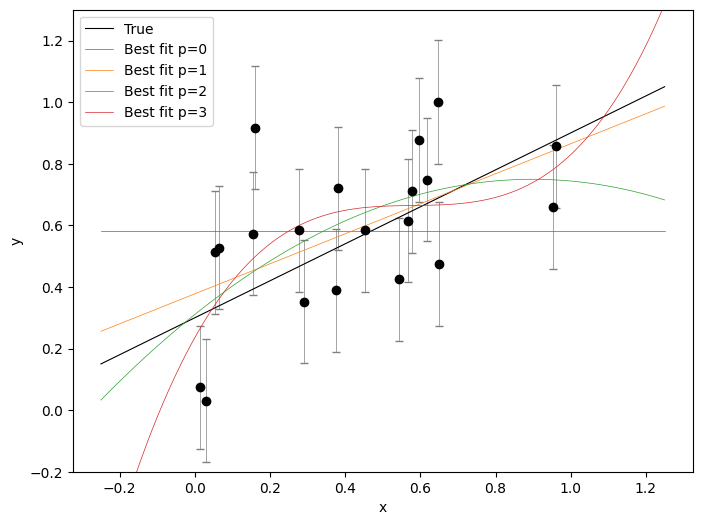

In [20]:
xplot = np.linspace(-0.25, 1.25, 100)
Gplot = getG(xplot, 1)
dplot = np.dot(Gplot, mtrue)
#
plt.figure(figsize=(8, 6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt="ko", ecolor="grey", lw=0.5)
plt.plot(xplot, dplot, label="True", color="k", lw=0.8)
for i in range(maxorder + 1):
    Gplotp = getG(xplot, i)
    dpred = np.dot(Gplotp, mls[i])
    plt.plot(xplot, dpred, label="Best fit p=" + str(i), lw=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-0.2, 1.3)
plt.legend()
plt.show()

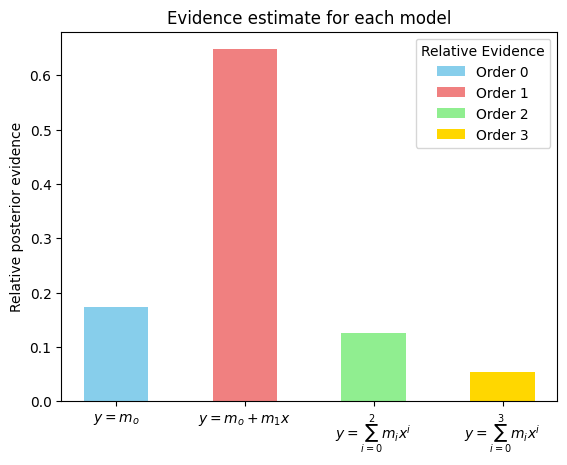

In [21]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [
    r"$y=m_o$",
    r"$y=m_o + m_1x$",
    r"$y = \sum_{i=0}^2 m_ix^i$",
    r"$y = \sum_{i=0}^3 m_ix^i$",
]
counts = [Ev[i] for i in range(maxorder + 1)]
bar_labels = [
    "Order 0",
    "Order 1",
    "Order 2",
    "Order 3",
]  # Define a list of labels, one for each bar

bar_colors = [
    "skyblue",
    "lightcoral",
    "lightgreen",
    "gold",
]  # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5, color=bar_colors)

ax.set_ylabel("Relative posterior evidence")
ax.set_title("Evidence estimate for each model")
ax.legend(title="Relative Evidence")

plt.show()

----------------

Set some global control parameters.

In [22]:
plotting = True  # Create some diagnostic displays of outputs
parallel = False  # Use parallel computation for sampling

### Log-posterior Likeihood, prior and PDF for each state

In [23]:
def _log_likelihood(x, state, dobs, G, Cdinv):
    """Calculate the log likelihood of the data given the model parameters."""
    dpred = np.dot(G[state], x)
    misfit = 0.5 * (np.dot((dobs - dpred), np.dot(Cdinv, (dobs - dpred))))
    f = np.sqrt(2 * np.pi) ** len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) - misfit + np.log(detCdinv)
    return logL


log_likelihood = partial(_log_likelihood, dobs=dobs, G=G, Cdinv=Cdinv)

In [24]:
def _log_prior(x, state, muprior, Cmprior):
    """Calculate the log prior probability of the model parameters."""
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(
        mean=mu, cov=cov
    )  # instance of multi-dimensional Gaussian
    return rv.logpdf(x)


log_prior = partial(_log_prior, muprior=muprior, Cmprior=Cmprior)

In [25]:
def log_posterior(x, state):
    """Multi-state log Posterior PDF evaluation (unormalised)."""
    return log_likelihood(x, state) + log_prior(x, state)

In [26]:
# first we optimize each state to find good starting point for all McMC samplers
rng = np.random.default_rng(42)
nstates = maxorder + 1  # Number of distinct states
ndims = [1, 2, 3, 4]  # Number of model parameters in each stateif(True):
nll = lambda *args: -log_posterior(*args)
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5 * np.ones(i + 1)
    soln = minimize(nll, initial, args=(i,))
    ml.append(soln.x)
    print("x_ml ", soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664354]
x_ml  [ 0.31354801  0.95796058 -0.52400541]
x_ml  [ 0.28548373  1.4395107  -1.83289387  0.89632873]


## Trans-C samping across model states with the Ensemble resampler 

Here we demonstrate use of the *Ensemble resampler*.

This formulation is equivalent to the *State-jump sampler* with the pseudo-prior being an approximation of the posterior PDF in each state. 

This consists of the following steps:
- Generate posterior ensembles in each state
- Build a pseudo prior PDF from these ensembles, and evaluate its log for all models in the ensembles.
- Sampler across the ensembles over the integer state label variable, $k$.

Run Ensemble resampler in each state separately.

### Preliminaries 

First find good starting models in each state, and then run Ensemble resampler in each state separately.

In [27]:
# setup of MCMC sampler
nsamples_es = 4 * [50000]  # number of samples per chain for sampling of each state
nwalkers_es = 4 * [32]  # number of mcmc chains to run in each state
pos = []
for i in range(nstates):  # generate starting points for each chain in each state
    pos.append(
        ml[i] + 1e-4 * rng.standard_normal((nwalkers_es[i], ndims[i]))
    )  # add random perturbation to maximum Likelihood models

#### Parallelisation
`run_mcmc_per_state` performs posterior sampling within each state using MCMC. Since this process is *embarrisingly parallel* over states, and may separately be parallelized across chains within each state, we expose two pools that the user may define. One over states and one over walkers. Both may be used simultaneously. This is implemented using the following options:

- `parallel_mode = 0` :Sequential execution (no pool).
- `parallel_mode = 1` :Parallel across states only. Set `n_state_procs` to a factor of the number of states.
- `parallel_mode = 2` :Parallel across states and walkers within each state. Set `n_state_procs` to a factor of the number of states and  `n_walker_procs` to a factor of the number of walkers within each state.

For a more detailed examination of how performance varies with these choices see the notebook `TransC_Regression_parallel.ipynb`.

In [28]:
parallel_mode = 1      # Implement choice of Parallel mode
if (parallel_mode == 1):
    n_state_procs = 4  # Number of processes used in state mode. Suggest set equal to number of states if possible.
elif(parallel_mode == 2):
    n_state_procs = 4  # Number of processes over states. Suggest set equal to number of states if possible.
    n_walker_procs = 8 # Number of processes used over walkers within each state

In [29]:
# run Ensemble sampler in each state
start_time = time.time()
if(parallel_mode == 0): # No parallelisation
    ensemble_per_state, log_posterior_ens = run_mcmc_per_state(
        nstates,  # number of states
        ndims,  # number of dimensions in each state
        nwalkers_es,  # int or list containing number of walkers for each state
        nsamples_es,  # number of chain steps per walker
        pos,  # starting positions for walkers in each state
        log_posterior,  # log Likelihood x log_prior
        discard=0,  # burnin number of chain steps to discard in eeach state
        auto_thin=True,  # thinning value, save every `thin` models
        verbose=True)  # show progress bar for each state

elif(parallel_mode == 1): # Parallel over states only
    with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool:
            ensemble_per_state, log_posterior_ens = run_mcmc_per_state(
                nstates,
                ndims,
                nwalkers_es,
                nsamples_es,
                pos,
                log_posterior,
                discard=0,
                state_pool=state_pool,
                auto_thin=True
            )
elif(parallel_mode == 2): # Parallel over states and walkers
    with ProcessPoolExecutor(max_workers=n_state_procs) as state_pool, \
         ProcessPoolExecutor(max_workers=n_walker_procs) as walker_pool:
    
        ensemble_per_state, log_posterior_ens = run_mcmc_per_state(
            nstates,
            ndims,
            nwalkers_es,
            nsamples_es,
            pos,
            log_posterior=log_posterior,
            state_pool=state_pool,
            emcee_pool=walker_pool,
        )

elapsed_time = time.time() - start_time
print(
    " Elapsed time                                     :",
    np.round(elapsed_time, 2),
    "s \n",
)
print(
    " Number of samples in each state                  :",
    *[len(ensemble_per_state[i]) for i in range(nstates)],
)


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32, 32]

Number of states being sampled:  4
Dimensions of each state:  [1, 2, 3, 4]
Using state-level parallelism


100%|███████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:46<00:00, 467.87it/s]


Performing auto thinning of ensemble...
 Elapsed time                                     : 107.4 s 

 Number of samples in each state                  : 114282 94114 79996 63996


#### Run times in each mode

| Mode | Elapsed time (s) | Nproc_state |Nproc_walkers| N state 1 |N state 2| N state 3|N state 4|
|:-------------|-------------:|:--------------:|:--------------:|:----------:|:----------:|:----------:|:----------:|
| Sequential   | 447.0        | -           |-           |114282| 94114| 79996| 63996|
| State parallel | 117.9      | 4          |-           |114282| 94114| 79996| 63996|
| State-Walker parallel | 251.9     | 4          |8           |114282| 94114| 79996| 63996|

Relative execution times may be dependent on the cost of a Likelihood evaluation, which is quite fast here.

In [30]:
# corner plots to check sampling within each state (if desired)
if False:
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "darkblue"}
    data_kwargs = {"color": "slateblue"}
    for i in range(1, nstates):
        string = "Order " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            ensemble_per_state[i],
            truths=ml[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )

#### Build pseudo priors by fitting a Gaussian mixture to posterior ensembles in each state

Fit a mixture model in each state to create an automatic pseudo prior, and then evaluate that pseudo_prior for all points in the ensembles. This uses the posterior ensembles `ensemble_per_state[s],s=1,...,nstates` and produces an ensemble of log-pseudo-prior values which are placed in `log_pseudo_prior_ens[s],s=1,...,nstates`. These are then provided to the ensemble resampler `run_ensemble_resampler`.

In [ ]:
log_pseudo_prior = build_auto_pseudo_prior(ensemble_per_state=ensemble_per_state)
log_pseudo_prior_ens = []
for i, ens in enumerate(ensemble_per_state):
    log_pseudo_prior_ens.append(np.array([log_pseudo_prior(x, i) for x in ens]))

In [ ]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers_er = 32  # number of independent random walkers across ensembles
nsteps_er = 100000  # number of chain steps for each walker
start_time = time.time()
resampler_chains = run_ensemble_resampler(
    nwalkers_er,
    nsteps_er,
    nstates,
    ndims,
    log_posterior_ens=log_posterior_ens,
    log_pseudo_prior_ens=log_pseudo_prior_ens,
    parallel=parallel,
    progress=True,
)  # run mcmc sampler over ensembles to get marginal Likelihoods between states
elapsed_time = time.time() - start_time

alg = "TransC-ensemble-resampler"
state_chain_tot = np.swapaxes(resampler_chains.state_chain_tot, 0, 1)
state_chain = resampler_chains.state_chain.T
accept_within_per_walker = 1.0 * np.ones(nwalkers_er)
accept_between_per_walker = resampler_chains.n_accepted / nsteps_er
accept_within = 100 * np.mean(accept_within_per_walker)
accept_between = 100 * np.mean(accept_between_per_walker)
nsamples = [len(a) for a in log_posterior_ens]

In [ ]:
# print some diagnostics
print("\n Algorithm type                                      :", alg)
print(
    " Average % acceptance rate for within states         :",
    np.round(accept_within, 2),
)
print(
    " Average % acceptance rate for between states        :",
    np.round(accept_between, 2),
)

# extract trans-D samples and chains
discard = 0  # chain burnin
thin = 15  # chain thinning
visits, states_chain = get_visits_to_states(
    transc_sampler=resampler_chains,
    discard=discard,
    thin=thin,
    normalize=True,
)
visits = visits.swapaxes(0, 1)  # (n_steps, n_walkers, n_states)
states_chain = states_chain.swapaxes(0, 1)  # (n_steps, n_walkers)

state_changes_per_walker = count_state_changes(
    resampler_chains.state_chain, discard=discard, thin=thin
)
total_state_changes = count_total_state_changes(
    resampler_chains.state_chain, discard=discard, thin=thin
)
acceptance_rate_between_states = get_acceptance_rate_between_states(
    resampler_chains, discard=discard, thin=thin
)
autocorr_time_for_between_state_jumps = get_autocorr_between_state_jumps(
    resampler_chains.state_chain
)
relative_marginal_likelihoods = get_relative_marginal_likelihoods(
    resampler_chains.state_chain_tot[:, -1, :]
)

print(
    " Auto correlation time for between state sampling    :",
    np.round(autocorr_time_for_between_state_jumps, 3),
)
print(" Total number of state changes for all walkers       :", total_state_changes)
print(
    " Number of state changes for each walker             :\n",
    *state_changes_per_walker,
)
print(" Analytic relative marginal Likelihoods              :", *np.round(Ev, 5))
print(
    " Estimated relative evidences                        :",
    *np.round((relative_marginal_likelihoods), 5),
)
print(
    " Elapsed time                                        :",
    np.round(elapsed_time, 2),
    "s \n",
)

In [ ]:
# plot relative number of visit to each state along the chain
if plotting:
    fig, axes = plt.subplots(figsize=(8, 6))
    if visits.ndim == 3:  # plot chains for each state and walker
        plt.semilogx(visits.reshape(np.shape(visits)[0], -1), lw=0.75)
    elif visits.ndim == 2:  # plot chains for each state average over walkers
        plt.semilogx(
            visits.reshape(np.shape(visits)[0], -1),
            lw=0.75,
            label=["State 1", "State 2", "State 3"],
        )
        plt.legend()
    plt.xlabel("Chain step")
    plt.ylabel("Relative Evidence")
    plt.plot(len(visits) * 1.3, Ev[0], "bo")
    plt.plot(len(visits) * 1.3, Ev[1], "o", color="orange")
    plt.plot(len(visits) * 1.3, Ev[2], "go")
    plt.plot(len(visits) * 1.3, Ev[3], "mo")
    plt.title(" Convergence of " + alg)
    plt.ylim(-0.05, 1.0)
    # plt.savefig('ER_chains.pdf')

    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains are 
converging, and visiting each state in proportion to the correct normalization constant. 

In [ ]:
# Count visits to each state by Trans-D mcmc
if plotting:
    h = np.zeros(nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(
        Counter(states_chain.reshape(-1)).values()
    )
    h /= np.sum(h)
    # plot histogram of frequency of visits to each state

    labels = [
        r"$y=m_o$",
        r"$y=m_o + m_1x$",
        r"$y = \sum_{i=0}^2 m_ix^i$",
        r"$y = \sum_{i=0}^3 m_ix^i$",
    ]
    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h, 3), width, label=alg, color="skyblue")
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier + 0.05
    rects = ax.bar(
        x + offset, np.round(counts, 3), width, label="Analytical", color="lightcoral"
    )
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(" Proportion of visits to each state")
    ax.set_title("Relative Evidence")
    ax.set_xticks(x + width / 2, labels)
    ax.legend(loc="upper right")
    # plt.savefig('ER_relative_evidences.pdf')
    plt.show()

In [ ]:
# corner plots to check sampling within each state
if plotting:
    muplot = mls.copy()
    muplot[1] = mtrue
    # collect trans samples
    transc_ensemble = resample_ensembles(
        ensemble_per_state,
        relative_marginal_likelihoods,
        100_000,
    )
    contour_kwargs = {"linewidths": 0.5}
    data_kwargs = {"color": "slateblue"}
    for i in range(1, nstates):
        string = "Order " + str(i)
        print(" State; ", i, " in ", ndims[i], " dimensions")
        fig = corner.corner(
            transc_ensemble[i],
            truths=muplot[i],
            title=string,
            bins=40,
            hist_bin_factor=2,
            smooth=True,
            contour_kwargs=contour_kwargs,
            data_kwargs=data_kwargs,
        )
# fig.savefig('ER_corner_'+str(i)+'.pdf')

In [ ]:
print(
    f" Here is the Trans-C ensemble with\n {len(transc_ensemble[0])} samples in state 1\n {len(transc_ensemble[1])} samples in state 2\n {len(transc_ensemble[2])} samples in state 3\n",
    "\n",
    transc_ensemble,
)

---------